In [1]:
# uv 설치
!pip install uv -q

# transformers GitHub 최신 버전 + 필요 패키지 설치
!uv pip install --system git+https://github.com/huggingface/transformers.git
!uv pip install --system accelerate huggingface_hub torch torchvision matplotlib pillow
!uv pip install --system moviepy opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 88.7 MB/s eta 0:00:00
Using Python 3.12.12 environment at: /usr
Resolved 25 packages in 21.34s
Prepared 2 packages in 4.13s
Uninstalled 2 packages in 295ms
Installed 2 packages in 49ms
 - huggingface-hub==0.36.0
 + huggingface-hub==1.3.2
 - transformers==4.57.3
 + transformers==5.0.0.dev0 (from git+https://github.com/huggingface/transformers.git@5c773b8a84677192d4a52edc1e2c8823f9c1dcea)
Using Python 3.12.12 environment at: /usr
Audited 6 packages in 109ms
Using Python 3.12.12 environment at: /usr
Audited 2 packages in 96ms


In [2]:
import os
from google.colab import userdata
from huggingface_hub import login, whoami

# Colab Secrets에서 토큰 가져오기
try:
    HF_TOKEN = userdata.get('HF_TOKEN').strip()
    print("✅ Hugging Face 토큰을 Colab Secrets에서 불러왔습니다.")
except Exception as e:
    print(f"⚠️ Colab Secrets에서 토큰을 가져오지 못했습니다: {e}")
    HF_TOKEN = input("Hugging Face 토큰을 입력하세요: ").strip()

# 로그인
login(token=HF_TOKEN, add_to_git_credential=False)

# 로그인 확인
try:
    user_info = whoami()
    print(f"✅ 로그인 성공! 사용자: {user_info['name']}")
except Exception as e:
    print(f"❌ 로그인 실패: {e}")

✅ Hugging Face 토큰을 Colab Secrets에서 불러왔습니다.
✅ 로그인 성공! 사용자: jiyun12


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import requests
import cv2
import urllib.request

# 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Using device: {device}")

def overlay_masks(image, masks):
    """마스크를 이미지 위에 오버레이"""
    image = image.convert("RGBA")
    masks_np = 255 * masks.cpu().numpy().astype(np.uint8)

    n_masks = masks_np.shape[0]
    if n_masks == 0:
        return image

    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [tuple(int(c * 255) for c in cmap(i)[:3]) for i in range(n_masks)]

    for mask, color in zip(masks_np, colors):
        mask_img = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask_img.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)
    return image

def show_comparison(original, result_image, title="Segmentation"):
    """원본과 결과 비교"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(result_image)
    axes[1].set_title(title)
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

def load_video_cv2(video_path):
    """OpenCV로 비디오 로드"""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)

    cap.release()
    return np.array(frames), fps

print("✅ 시각화 함수 정의 완료!")

🖥️ Using device: cuda
✅ 시각화 함수 정의 완료!


In [4]:
from transformers import Sam3Processor, Sam3Model

print("⏳ 이미지 모델 로딩 중...")
image_model = Sam3Model.from_pretrained("facebook/sam3", token=HF_TOKEN).to(device)
image_processor = Sam3Processor.from_pretrained("facebook/sam3", token=HF_TOKEN)
print("✅ 이미지 모델 로딩 완료!")

⏳ 이미지 모델 로딩 중...


config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

processor_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

✅ 이미지 모델 로딩 완료!


### 왼쪽 라인

📂 총 6개의 이미지를 발견했습니다.

--- [1/6] 처리 중: 금곡교.png ---
✅ 저장 완료: /content/drive/MyDrive/highway_seg/left_masks/mask_금곡교.png


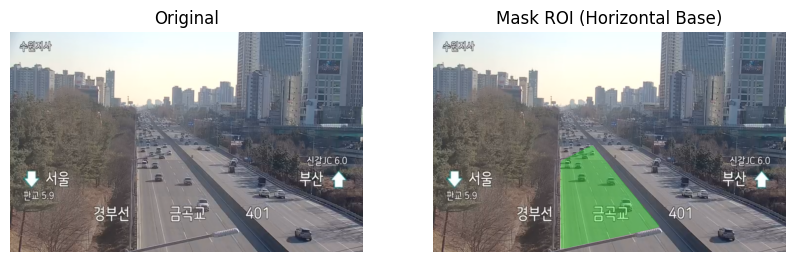


--- [2/6] 처리 중: 달래내2.png ---
✅ 저장 완료: /content/drive/MyDrive/highway_seg/left_masks/mask_달래내2.png


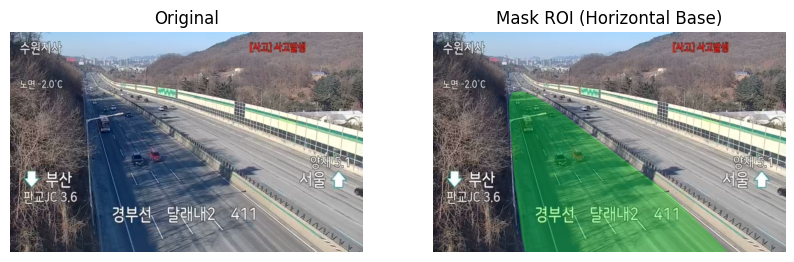


--- [3/6] 처리 중: 서초.png ---
✅ 저장 완료: /content/drive/MyDrive/highway_seg/left_masks/mask_서초.png


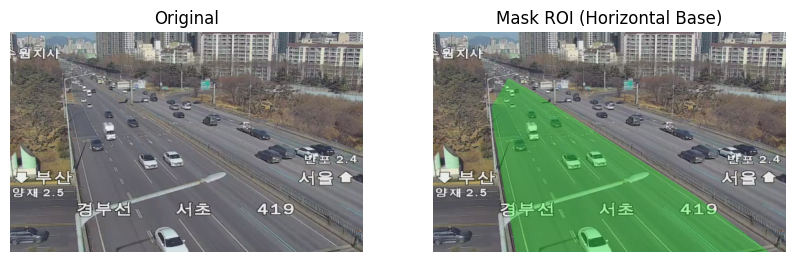


--- [4/6] 처리 중: 수원.png ---
✅ 저장 완료: /content/drive/MyDrive/highway_seg/left_masks/mask_수원.png


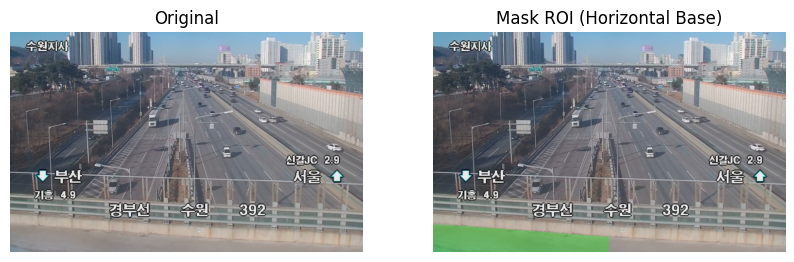


--- [5/6] 처리 중: 신갈분기점.png ---
✅ 저장 완료: /content/drive/MyDrive/highway_seg/left_masks/mask_신갈분기점.png


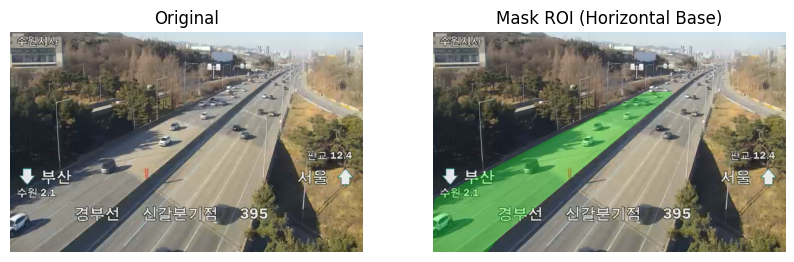


--- [6/6] 처리 중: 판교3.png ---
✅ 저장 완료: /content/drive/MyDrive/highway_seg/left_masks/mask_판교3.png


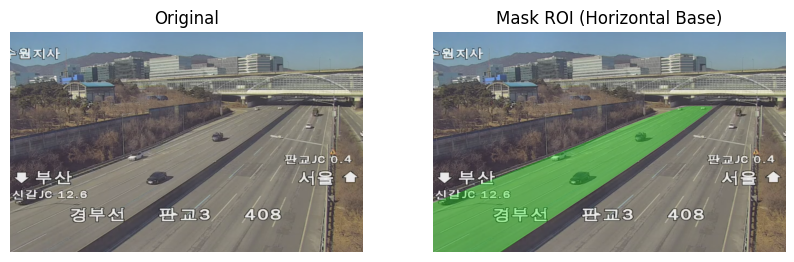


✨ 모든 작업이 완료되었습니다. 'masks' 폴더를 확인하세요.


In [5]:
import numpy as np
import cv2
import torch
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt

# 0. 설정 및 경로 지정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# [수정 포인트] 경로를 본인의 환경에 맞게 수정하세요
input_folder = "/content/drive/MyDrive/highway_seg"
output_folder = "/content/drive/MyDrive/highway_seg/left_masks"
os.makedirs(output_folder, exist_ok=True)

image_files = sorted(glob.glob(os.path.join(input_folder, "*.[jp][pn]g")))

if not image_files:
    print(f"❌ '{input_folder}' 폴더에 이미지 파일이 없습니다.")
else:
    print(f"📂 총 {len(image_files)}개의 이미지를 발견했습니다.")

# --- 이미지별 반복 처리 시작 ---
for idx, image_path in enumerate(image_files):
    file_name = os.path.basename(image_path)
    print(f"\n--- [{idx+1}/{len(image_files)}] 처리 중: {file_name} ---")

    # 1. 이미지 로드
    try:
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image).copy()
        h, w = image_np.shape[:2]
    except Exception as e:
        print(f"❌ 이미지 로드 실패: {e}")
        continue

    # --- [STEP 1: 중앙 가드레일 찾기 및 왼쪽 영역 제한] ---
    inputs_g = image_processor(images=image, text="guardrail", return_tensors="pt").to(device)
    with torch.no_grad():
        outputs_g = image_model(**inputs_g)
    results_g = image_processor.post_process_instance_segmentation(
        outputs_g, threshold=0.5, target_sizes=[(h, w)]
    )[0]

    left_region_mask = np.ones((h, w), dtype=np.uint8)

    if len(results_g['masks']) > 0:
        best_g_mask = None
        min_dist_to_center = float('inf')
        img_center_x = w / 2

        for i in range(len(results_g['masks'])):
            current_mask = results_g['masks'][i].cpu().numpy().astype(np.uint8)
            coords = np.column_stack(np.where(current_mask > 0))
            if len(coords) > 50:
                avg_x = np.mean(coords[:, 1])
                dist = abs(img_center_x - avg_x)
                if dist < min_dist_to_center:
                    min_dist_to_center = dist
                    best_g_mask = current_mask
                    best_coords = coords

        if best_g_mask is not None:
            # 가드레일 경계선을 다항식으로 근사화하여 왼쪽 영역 생성
            y_c, x_c = best_coords[:, 0], best_coords[:, 1]
            coeffs = np.polyfit(y_c, x_c, 2)
            poly_func = np.poly1d(coeffs)
            left_region_mask = np.zeros((h, w), dtype=np.uint8)
            for y in range(h):
                x_boundary = int(poly_func(y))
                if 0 <= x_boundary < w:
                    left_region_mask[y, :x_boundary] = 1
                elif x_boundary >= w:
                    left_region_mask[y, :] = 1

    # --- [STEP 2: 도로 탐지 및 필터링] ---
    inputs_r = image_processor(images=image, text="road", return_tensors="pt").to(device)
    with torch.no_grad():
        outputs_r = image_model(**inputs_r)
    results_r = image_processor.post_process_instance_segmentation(
        outputs_r, threshold=0.3, target_sizes=[(h, w)]
    )[0]

    if len(results_r['masks']) > 0:
        combined_road = np.zeros((h, w), dtype=np.uint8)
        for r_mask in results_r['masks']:
            combined_road = np.maximum(combined_road, r_mask.detach().cpu().numpy().astype(np.uint8))

        # 가드레일 왼쪽의 도로만 추출
        filtered_road = cv2.bitwise_and(combined_road, combined_road, mask=left_region_mask)

        # --- [STEP 3: 메인 덩어리 추출 및 사다리꼴 보정] ---
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(filtered_road, connectivity=8)

        if num_labels > 1:
            largest_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
            main_road_mask = np.where(labels == largest_label, 1, 0).astype(np.uint8)

            # 사다리꼴(Convex Hull) 및 수평 밑변 보정
            contours, _ = cv2.findContours(main_road_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                cnt = max(contours, key=cv2.contourArea)
                hull = cv2.convexHull(cnt)

                # 밑변 수평 보정 로직
                hull_pts = hull.reshape(-1, 2)
                y_max = np.max(hull_pts[:, 1])
                # 바닥 근처(하단 5%) 점들의 y값을 y_max로 통일하여 수평 유지
                hull_pts[hull_pts[:, 1] > y_max * 0.95, 1] = y_max

                final_road = np.zeros((h, w), dtype=np.uint8)
                cv2.fillPoly(final_road, [hull_pts.astype(np.int32)], 1)
            else:
                final_road = main_road_mask
        else:
            final_road = filtered_road

        # --- [STEP 4: 마스크 저장 및 시각화] ---
        # 1. 파일 저장 (PNG, 0 or 255)
        mask_255 = (final_road * 255).astype(np.uint8)
        save_name = f"mask_{os.path.splitext(file_name)[0]}.png"
        save_path = os.path.join(output_folder, save_name)
        cv2.imwrite(save_path, mask_255)
        print(f"✅ 저장 완료: {save_path}")

        # 2. 시각화 (선택 사항)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        # 원본 위에 반투명하게 도로 표시
        overlay = image_np.copy()
        overlay[final_road == 1] = [0, 255, 0]
        vis = cv2.addWeighted(image_np, 0.7, overlay, 0.3, 0)
        plt.imshow(vis)
        plt.title(f"Mask ROI (Horizontal Base)")
        plt.axis('off')
        plt.show()

    else:
        print(f"⚠️ {file_name}에서 도로를 찾지 못했습니다.")

print("\n✨ 모든 작업이 완료되었습니다. 'masks' 폴더를 확인하세요.")

### 오른쪽 라인

📂 총 6개의 이미지를 발견했습니다.

--- [1/6] 처리 중: 금곡교.png ---
💾 마스크 저장 완료: /content/drive/MyDrive/highway_seg/right_masks/mask_금곡교.png


/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4352 (\N{HANGUL CHOSEONG KIYEOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4467 (\N{HANGUL JUNGSEONG EU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4535 (\N{HANGUL JONGSEONG MIEUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4457 (\N{HANGUL JUNGSEONG O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4520 (\N{HANGUL JONGSEONG KIYEOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4461 (\N{HANGUL JUNGSEONG YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4352 (\N{HANGUL CHOSEONG KIYEOK}) missing from f

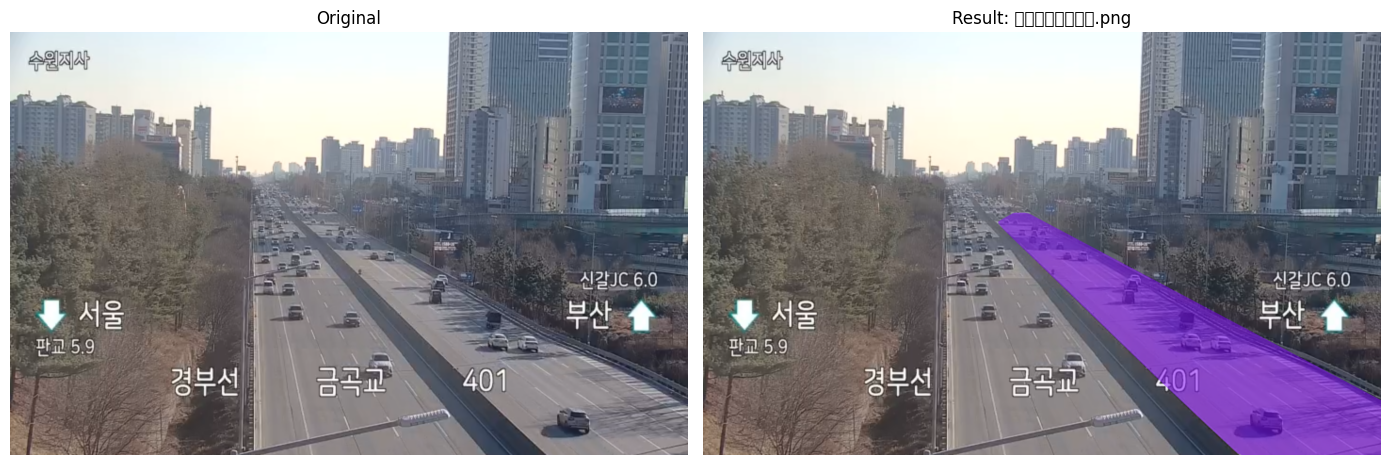


--- [2/6] 처리 중: 달래내2.png ---
💾 마스크 저장 완료: /content/drive/MyDrive/highway_seg/right_masks/mask_달래내2.png


/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4355 (\N{HANGUL CHOSEONG TIKEUT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4449 (\N{HANGUL JUNGSEONG A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4527 (\N{HANGUL JONGSEONG RIEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4357 (\N{HANGUL CHOSEONG RIEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4450 (\N{HANGUL JUNGSEONG AE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4354 (\N{HANGUL CHOSEONG NIEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4355 (\N{HANGUL CHOSEONG TIKEUT}) missing from f


--- [3/6] 처리 중: 서초.png ---
💾 마스크 저장 완료: /content/drive/MyDrive/highway_seg/right_masks/mask_서초.png


/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4361 (\N{HANGUL CHOSEONG SIOS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4453 (\N{HANGUL JUNGSEONG EO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4366 (\N{HANGUL CHOSEONG CHIEUCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4361 (\N{HANGUL CHOSEONG SIOS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4453 (\N{HANGUL JUNGSEONG EO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4366 (\N{HANGUL CHOSEONG CHIEUCH}) missing from font(s) DejaVu Sans.
  fig.canvas

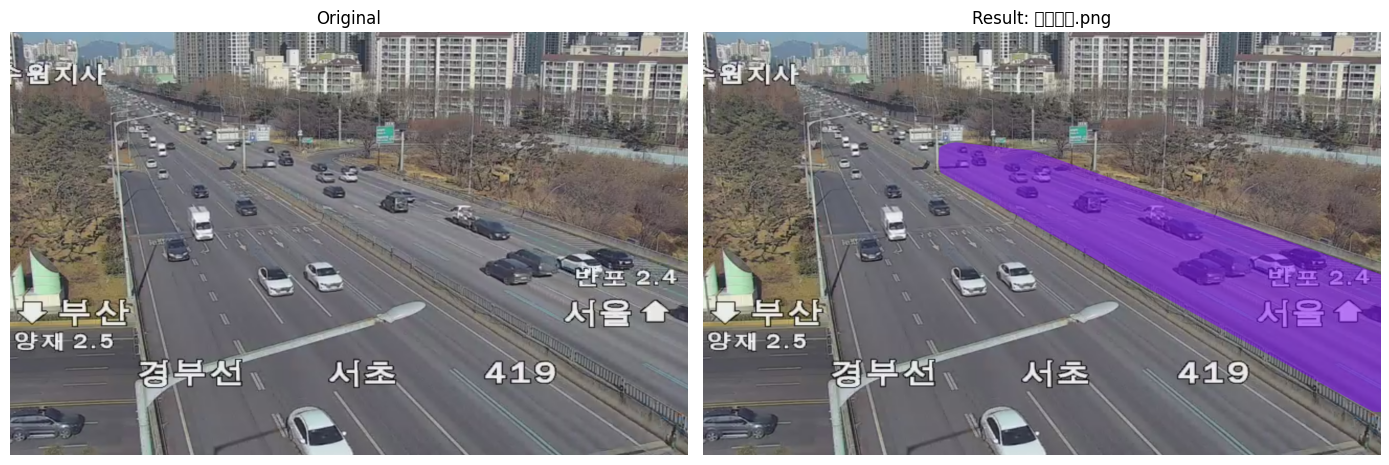


--- [4/6] 처리 중: 수원.png ---
💾 마스크 저장 완료: /content/drive/MyDrive/highway_seg/right_masks/mask_수원.png


/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4462 (\N{HANGUL JUNGSEONG U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4363 (\N{HANGUL CHOSEONG IEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4463 (\N{HANGUL JUNGSEONG WEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4523 (\N{HANGUL JONGSEONG NIEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4462 (\N{HANGUL JUNGSEONG U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4363 (\N{HANGUL CHOSEONG IEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist

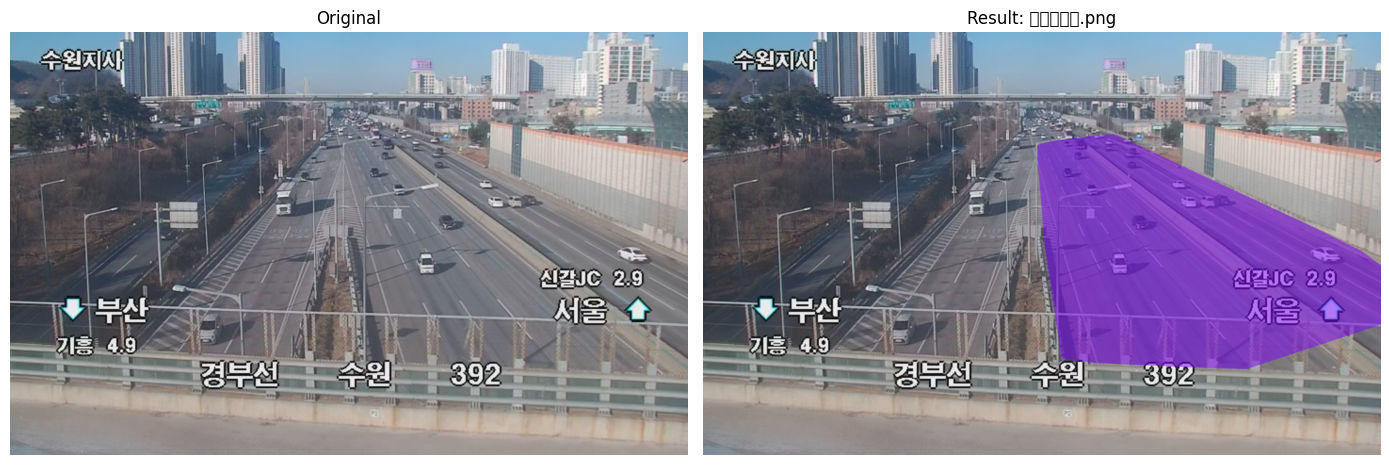


--- [5/6] 처리 중: 신갈분기점.png ---
💾 마스크 저장 완료: /content/drive/MyDrive/highway_seg/right_masks/mask_신갈분기점.png


/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4469 (\N{HANGUL JUNGSEONG I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4359 (\N{HANGUL CHOSEONG PIEUP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4364 (\N{HANGUL CHOSEONG CIEUC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4469 (\N{HANGUL JUNGSEONG I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4359 (\N{HANGUL CHOSEONG PIEUP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4364 (\N{HANGUL CHOSEONG CIEUC}) missing from font(s) DejaVu Sans.
  fig.canvas.pri

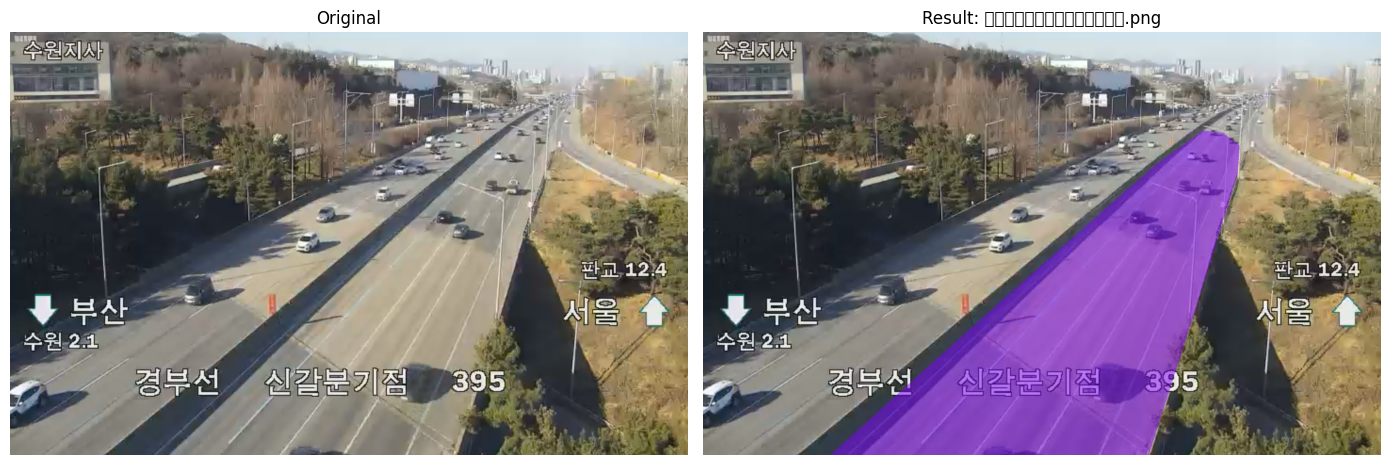


--- [6/6] 처리 중: 판교3.png ---
💾 마스크 저장 완료: /content/drive/MyDrive/highway_seg/right_masks/mask_판교3.png


/tmp/ipython-input-2290017191.py:43: UserWarning: Glyph 4369 (\N{HANGUL CHOSEONG PHIEUPH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4369 (\N{HANGUL CHOSEONG PHIEUPH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


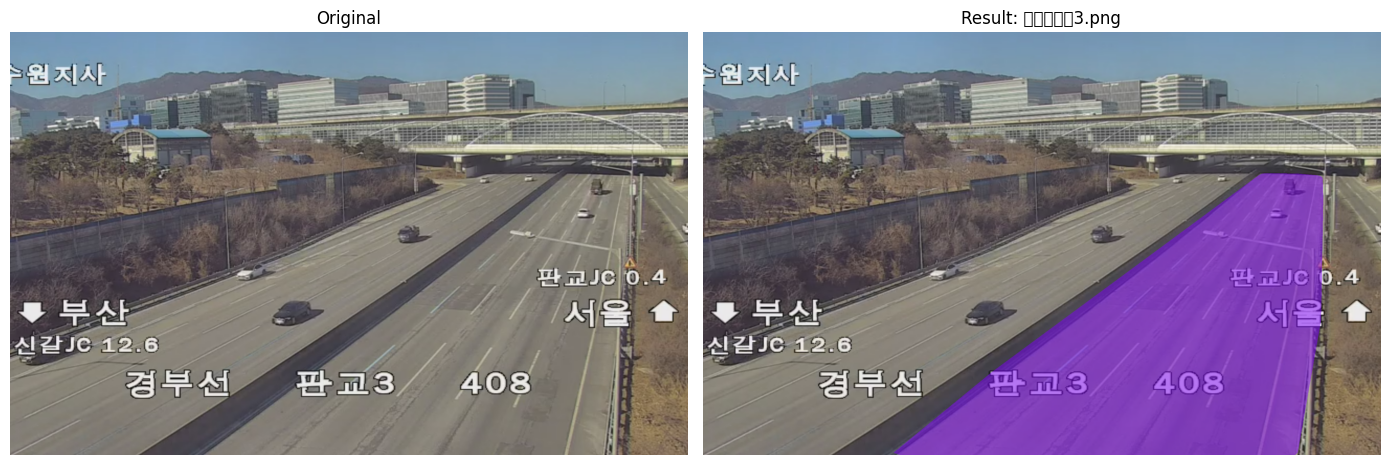


✨ 모든 이미지 처리 및 파일 저장이 완료되었습니다.


In [6]:
# 오른쪽 코드
import numpy as np
import cv2
import torch
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt

# 0. 설정 및 경로 지정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_folder = "/content/drive/MyDrive/highway_seg"
output_folder = "/content/drive/MyDrive/highway_seg/right_masks" # 저장할 폴더

# 출력 폴더가 없으면 생성
os.makedirs(output_folder, exist_ok=True)

# 폴더 내 이미지 파일 확장자들 가져오기
image_files = sorted(glob.glob(os.path.join(input_folder, "*.[jp][pn]g")))

if not image_files:
    print(f"❌ '{input_folder}' 폴더에 이미지 파일이 없습니다.")
else:
    print(f"📂 총 {len(image_files)}개의 이미지를 발견했습니다.")

# --- 이미지별 반복 처리 시작 ---
for idx, image_path in enumerate(image_files):
    filename = os.path.basename(image_path)
    print(f"\n--- [{idx+1}/{len(image_files)}] 처리 중: {filename} ---")

    # 1. 이미지 로드
    try:
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        h, w = image_np.shape[:2]
    except Exception as e:
        print(f"❌ 이미지 로드 실패: {e}")
        continue

    # --- [STEP 1: 중앙 가드레일 찾기] ---
    text_prompt_g = "guardrail"
    inputs_g = image_processor(images=image, text=text_prompt_g, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs_g = image_model(**inputs_g)

    results_g = image_processor.post_process_instance_segmentation(
        outputs_g, threshold=0.5, mask_threshold=0.5,
        target_sizes=inputs_g.get("original_sizes").tolist()
    )[0]

    # 기본값은 전체 영역 (가드레일을 못 찾을 경우 대비)
    right_region_mask = np.ones((h, w), dtype=np.uint8)

    if len(results_g['masks']) > 0:
        best_g_mask = None
        min_dist_to_center = float('inf')
        img_center_x = w / 2

        for i in range(len(results_g['masks'])):
            current_mask = results_g['masks'][i].cpu().numpy().astype(np.uint8)
            coords = np.column_stack(np.where(current_mask > 0))
            if len(coords) > 50:
                avg_x = np.mean(coords[:, 1])
                dist = abs(img_center_x - avg_x)
                if dist < min_dist_to_center:
                    min_dist_to_center = dist
                    best_g_mask = current_mask
                    best_coords = coords

        if best_g_mask is not None:
            y_coords, x_coords = best_coords[:, 0], best_coords[:, 1]
            coeffs = np.polyfit(y_coords, x_coords, 2)
            poly_func = np.poly1d(coeffs)

            # [수정] 가드레일 오른쪽 영역 마스크 생성
            right_region_mask = np.zeros((h, w), dtype=np.uint8)
            for y in range(h):
                x_boundary = int(poly_func(y))
                if x_boundary < 0:
                    right_region_mask[y, :] = 1 # 가드레일이 이미지 왼쪽 밖에 있으면 전체가 오른쪽
                elif 0 <= x_boundary < w:
                    right_region_mask[y, x_boundary:] = 1 # 가드레일 선부터 끝까지 채우기
                else:
                    right_region_mask[y, :] = 0 # 가드레일이 이미지 오른쪽 밖에 있으면 오른쪽 영역 없음

    # --- [STEP 2: 도로 찾기 및 가드레일 필터링] ---
    text_prompt_r = "road"
    inputs_r = image_processor(images=image, text=text_prompt_r, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs_r = image_model(**inputs_r)

    results_r = image_processor.post_process_instance_segmentation(
        outputs_r, threshold=0.3, mask_threshold=0.3,
        target_sizes=inputs_r.get("original_sizes").tolist()
    )[0]

    if len(results_r['masks']) > 0:
        combined_road = np.zeros((h, w), dtype=np.uint8)
        for r_mask in results_r['masks']:
            combined_road = np.maximum(combined_road, r_mask.detach().cpu().numpy().astype(np.uint8))

        # [수정] 가드레일 오른쪽 영역만 필터링
        filtered_road = cv2.bitwise_and(combined_road, combined_road, mask=right_region_mask)

        # --- [STEP 3: 최대 면적 덩어리(메인 도로)만 추출] ---
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
            filtered_road.astype(np.uint8), connectivity=8
        )

        if num_labels > 1:
            largest_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
            main_road_mask = np.where(labels == largest_label, 1, 0).astype(np.uint8)

            # 후처리: 내부 구멍 메우기 및 외곽선 보정 (차량 무시 효과)
            final_road = np.zeros_like(main_road_mask)
            contours, _ = cv2.findContours(main_road_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                hull = cv2.convexHull(cnt)
                cv2.fillPoly(final_road, [hull], 1)
        else:
            final_road = filtered_road

        # --- [STEP 4: 결과 저장 및 시각화] ---
        # 1. 파일 저장 (PNG)
        # 0과 1로 된 마스크를 0과 255로 변환하여 이미지 파일로 저장
        mask_save_path = os.path.join(output_folder, f"mask_{filename}")
        cv2.imwrite(mask_save_path, (final_road * 255).astype(np.uint8))
        print(f"💾 마스크 저장 완료: {mask_save_path}")

        # 2. 결과 시각화
        final_tensor = torch.from_numpy(final_road).unsqueeze(0).to(device)
        result_image = overlay_masks(image, final_tensor)
        show_comparison(image, result_image, f"Result: {filename}")

    else:
        print(f"⚠️ {filename}에서 도로를 찾지 못했습니다.")

print("\n✨ 모든 이미지 처리 및 파일 저장이 완료되었습니다.")